In [1]:
from titlecase import titlecase
import pandas as pd
from pandas import DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
import json
import joblib
import random

In [2]:
# Load cleaned csv
data_types = pd.read_csv('data/data_types.csv', index_col=0)['0'].to_dict()
df = pd.read_csv('data/energy_cleaned.csv', dtype=data_types)

In [3]:
df.head(2)

,total_consumption,in.sqft,"in.hvac_heating_efficiency / ASHP, SEER 10, 6.2 HSPF","in.hvac_heating_efficiency / ASHP, SEER 13, 7.7 HSPF","in.hvac_heating_efficiency / ASHP, SEER 15, 8.5 HSPF","in.hvac_heating_efficiency / Electric Baseboard, 100% Efficiency","in.hvac_heating_efficiency / Electric Boiler, 100% AFUE","in.hvac_heating_efficiency / Electric Furnace, 100% AFUE","in.hvac_heating_efficiency / Electric Wall Furnace, 100% AFUE","in.hvac_heating_efficiency / Fuel Boiler, 76% AFUE","in.hvac_heating_efficiency / Fuel Boiler, 80% AFUE","in.hvac_heating_efficiency / Fuel Boiler, 90% AFUE","in.hvac_heating_efficiency / Fuel Furnace, 60% AFUE","in.hvac_heating_efficiency / Fuel Furnace, 76% AFUE","in.hvac_heating_efficiency / Fuel Furnace, 80% AFUE","in.hvac_heating_efficiency / Fuel Furnace, 92.5% AFUE","in.hvac_heating_efficiency / Fuel Wall/Floor Furnace, 60% AFUE","in.hvac_heating_efficiency / Fuel Wall/Floor Furnace, 68% AFUE",in.hvac_heating_efficiency / None,in.hvac_heating_efficiency / Other,in.hvac_heating_efficiency / Shared Heating,in.hvac_heating_type_and_fuel / Electricity ASHP,in.hvac_heating_type_and_fuel / Electricity Baseboard,in.hvac_heating_type_and_fuel / Electricity Electric Boiler,in.hvac_heating_type_and_fuel / Electricity Electric Furnace,in.hvac_heating_type_and_fuel / Electricity Electric Wall Furnace,in.hvac_heating_type_and_fuel / Electricity Shared Heating,in.hvac_heating_type_and_fuel / Fuel Oil Fuel Boiler,in.hvac_heating_type_and_fuel / Fuel Oil Fuel Furnace,in.hvac_heating_type_and_fuel / Fuel Oil Fuel Wall/Floor Furnace,in.hvac_heating_type_and_fuel / Fuel Oil Shared Heating,in.hvac_heating_type_and_fuel / Natural Gas Fuel Boiler,in.hvac_heating_type_and_fuel / Natural Gas Fuel Furnace,in.hvac_heating_type_and_fuel / Natural Gas Fuel Wall/Floor Furnace,in.hvac_heating_type_and_fuel / Natural Gas Shared Heating,in.hvac_heating_type_and_fuel / None,in.hvac_heating_type_and_fuel / Propane Fuel Boiler,in.hvac_heating_type_and_fuel / Propane Fuel Furnace,in.hvac_heating_type_and_fuel / Propane Fuel Wall/Floor Furnace,in.hvac_heating_type_and_fuel / Propane Shared Heating,in.income / 10000-14999,in.income / 100000-119999,in.income / 120000-139999,in.income / 140000-159999,in.income / 15000-19999,in.income / 160000-179999,in.income / 180000-199999,in.income / 20000-24999,in.income / 200000+,in.income / 25000-29999,in.income / 30000-34999,in.income / 35000-39999,in.income / 40000-44999,in.income / 45000-49999,in.income / 50000-59999,in.income / 60000-69999,in.income / 70000-79999,in.income / 80000-99999,in.income / <10000,in.ashrae_iecc_climate_zone_2004_2_a_split / 1A,"in.ashrae_iecc_climate_zone_2004_2_a_split / 2A - FL, GA, AL, MS","in.ashrae_iecc_climate_zone_2004_2_a_split / 2A - TX, LA",in.ashrae_iecc_climate_zone_2004_2_a_split / 2B,in.ashrae_iecc_climate_zone_2004_2_a_split / 3A,in.ashrae_iecc_climate_zone_2004_2_a_split / 3B,in.ashrae_iecc_climate_zone_2004_2_a_split / 3C,in.ashrae_iecc_climate_zone_2004_2_a_split / 4A,in.ashrae_iecc_climate_zone_2004_2_a_split / 4B,in.ashrae_iecc_climate_zone_2004_2_a_split / 4C,in.ashrae_iecc_climate_zone_2004_2_a_split / 5A,in.ashrae_iecc_climate_zone_2004_2_a_split / 5B,in.ashrae_iecc_climate_zone_2004_2_a_split / 6A,in.ashrae_iecc_climate_zone_2004_2_a_split / 6B,in.ashrae_iecc_climate_zone_2004_2_a_split / 7A,in.ashrae_iecc_climate_zone_2004_2_a_split / 7B,"in.insulation_wall / Brick, 12-in, 3-wythe, R-11","in.insulation_wall / Brick, 12-in, 3-wythe, R-15","in.insulation_wall / Brick, 12-in, 3-wythe, R-19","in.insulation_wall / Brick, 12-in, 3-wythe, R-7","in.insulation_wall / Brick, 12-in, 3-wythe, Uninsulated","in.insulation_wall / CMU, 6-in Hollow, R-11","in.insulation_wall / CMU, 6-in Hollow, R-15","in.insulation_wall / CMU, 6-in Hollow, R-19","in.insulation_wall / CMU, 6-in Hollow, R-7","in.insulation_wall / CMU, 6-in Hollow, Uninsulated","in.insulation_wall / Wood Stud, R-11","in.insulation_wall / Wood Stud, R-15","in.insulation_wall / Wood Stud,

In [4]:
# These columns were identified as essentially duplicating information from other columns
# (duplicating in.sqft and in.geometry_stories but in different format):
df = df.drop(columns=[col for col in df.columns if 'in.geometry_floor_area' in col or col=='in.geometry_stories_low_rise'])

In [5]:
# Convert it to parquet for faster reading in future
# Also for 20 times more efficient storage
df.to_parquet('data/energy_cleaned.parquet')
df = pd.read_parquet('data/energy_cleaned.parquet')

In [6]:
# Show features of the cleaned dataset, together with units and description
features = list( {p: 0 for p in [col.split(' / ')[0] for col in df.columns[1:]]}.keys() )

col_descriptions = pd.read_csv('data/data_dictionary.tsv', sep='\t')
col_descriptions['data_type'][col_descriptions['data_type']=='integer'] = 'int'
dtypes = {col: dtype for col, dtype in zip(col_descriptions['field_name'], col_descriptions['data_type'])}
col_descriptions = col_descriptions[['field_name', 'units', 'field_description']]
col_descriptions = col_descriptions[col_descriptions['field_name'].isin(features)]
col_descriptions.set_index('field_name', inplace=True)
col_descriptions = col_descriptions.loc[features]

col_descriptions

,units,field_description
field_name,,
in.sqft,sqft,Finished floor area of the housing unit from within bin used for modeling purposes
in.hvac_heating_efficiency,NaN,Presence and efficiency of heating system
in.hvac_heating_type_and_fuel,NaN,"Presence, type, and fuel of heating system"
in.income,USD,Income level
in.ashrae_iecc_climate_zone_2004_2_a_split,NaN,IECC climate zone with split region 2A
in.insulation_wall,NaN,Wall construction type and insulation level
in.ducts,NaN,Duct insulation and leakage levels
in.water_heater_efficiency,NaN,"Efficiency, type, and heating fuel of water heater"
in.geometry_wall_exterior_finish,NaN,Exterior finish material and color


In [7]:
# Features that can be more or less realistically changed (not to None)
changeable_features = ['in.hvac_heating_efficiency', 
                       'in.hvac_heating_type_and_fuel', 
                       'in.insulation_wall', 
                       'in.ducts', 
                       'in.water_heater_efficiency', 
                       'in.hvac_cooling_efficiency', 
                       'in.clothes_dryer', 
                       'in.cooking_range', 
                       'in.hvac_shared_efficiencies', 
                       'in.windows', 
                       'in.insulation_ceiling', 
                       'in.insulation_roof', 
                       'in.clothes_washer', 
                       'in.dishwasher', 
                       'in.refrigerator', 
                       'in.hvac_cooling_partial_space_conditioning', 
                       'in.misc_extra_refrigerator', 
                       'in.heating_fuel', 
                       'in.insulation_slab', 
                       'in.window_areas', 
                       'in.insulation_floor', 
                       'in.insulation_foundation_wall', 
                       'in.insulation_rim_joist', 
                       'in.water_heater_fuel', 
                       'in.hvac_cooling_type', 
                       'in.hvac_heating_type', 
                       'in.misc_pool_heater', 
                       'in.lighting', 
                       'in.misc_hot_tub_spa']

In [8]:
# Unchangeable features either due to being unfeasible to change 
# or numerical features which cannot be changed to particular value
unchangeable_features = ['in.sqft', 
                         'in.income', 
                         'in.ashrae_iecc_climate_zone_2004_2_a_split', 
                         'in.geometry_wall_exterior_finish', 
                         'in.geometry_building_type_acs', 
                         'in.vintage', 
                         'in.roof_material', 
                         'in.neighbors', 
                         'in.geometry_foundation_type', 
                         'in.geometry_garage', 
                         'in.geometry_wall_type', 
                         'in.hvac_has_shared_system', 
                         'in.ceiling_fan', 
                         'in.geometry_attic_type', 
                         'in.hot_water_fixtures', 
                         'in.usage_level', 
                         'in.corridor', 
                         'in.hvac_has_zonal_electric_heating', 
                         'in.hvac_has_ducts', 
                         'in.misc_freezer', 
                         'in.misc_gas_fireplace', 
                         'in.misc_gas_grill', 
                         'in.misc_gas_lighting', 
                         'in.misc_pool_pump', 
                         'in.misc_well_pump', 
                         'in.radiant_barrier', 
                         'in.vacancy_status', 
                         'in.water_heater_in_unit', 
                         'in.bedrooms', 
                         'in.cooling_setpoint', 
                         'in.geometry_stories', 
                         'in.heating_setpoint', 
                         'in.infiltration', 
                         'in.occupants', 
                         'in.pv_system_size', 
                         'in.plug_loads']

In [9]:
def reformat_col_name(col):
    col = col.replace('in.', '')
    col = col.replace('sqft', 'floor_area')
    col = col.replace('_2004_2_a_split', '')
    col = col.replace('misc_', '')
    for abbreviation in ['hvac', 'ashrae', 'iecc', 'acs', 'pv']:
        col = col.replace(abbreviation, abbreviation.upper())
    col = col.replace('_', ' ')
    split = col.split(' / ')
    if len(split)>1:
        col = titlecase(split[0].strip()) + ' / ' + split[1].strip()
    else:
        col = titlecase(col.strip())
    return col

In [10]:
col_descriptions.index = col_descriptions.index.map(reformat_col_name)
df.columns = [reformat_col_name(col) for col in df.columns]
features = [reformat_col_name(col) for col in features]
changeable_features = [reformat_col_name(col) for col in changeable_features]
unchangeable_features = [reformat_col_name(col) for col in unchangeable_features]

In [11]:
def add_units_to_col_name(col):
    if not pd.isnull(col_descriptions.loc[col.split(' / ')[0], 'units']):
        units = ', ' + col_descriptions.loc[col.split(' / ')[0], 'units'].strip()
    else:
        units = ''
    
    split = col.split(' / ')
    if len(split)>1:
        col = split[0] + units + ' / ' + split[1]
    else:
        col = split[0] + units
    
    return col

In [12]:
df.columns = [df.columns[0]]+[add_units_to_col_name(col) for col in df.columns[1:]]
features = [add_units_to_col_name(col) for col in features]
changeable_features = [add_units_to_col_name(col) for col in changeable_features]
unchangeable_features = [add_units_to_col_name(col) for col in unchangeable_features]

In [13]:
col_descriptions.index = [col if pd.isnull(units) else col+', '+units for col, units in 
                          zip(col_descriptions.index, col_descriptions['units'])]
col_descriptions = col_descriptions.drop(columns=['units'])

# Model Training

In [14]:
df_train, df_test = train_test_split(df, test_size=50000, random_state=0)
df_train80, df_val = train_test_split(df_train, test_size=50000, random_state=1)
columns = list(df.columns)
print("Train / validation / test shapes:", df_train.shape, df_train80.shape, df_val.shape, df_test.shape)

Train / validation / test shapes: (498916, 381) (448916, 381) (50000, 381) (50000, 381)


In [15]:
X_train = df_train.drop(columns='Total Consumption')
y_train = np.log(df_train['Total Consumption'])
X_train80 = df_train80.drop(columns='Total Consumption')
y_train80 = np.log(df_train80['Total Consumption'])
X_val = df_val.drop(columns='Total Consumption')
y_val = np.log(df_val['Total Consumption'])
X_test = df_test.drop(columns='Total Consumption')
y_test = np.log(df_test['Total Consumption'])
del df_train, df_train80, df_val, df_test

In [16]:
# Histogram-based version is used to speed up the process
t00 = time()
depths = [d for d in range(1, 5)]
iterations = [i for i in range(1, 10001)]
hgb_best_iters = []
hgb_best_mses_train = []
hgb_best_mses_val = []
hgb_best_r2s_train = []
hgb_best_r2s_val = []

hgb_mses_train = np.zeros((max(iterations), max(depths)))
hgb_mses_val = np.zeros((max(iterations), max(depths)))
hgb_r2s_train = np.zeros((max(iterations), max(depths)))
hgb_r2s_val = np.zeros((max(iterations), max(depths)))

for depth in depths:
    t0 = time()
    print(f'Max depth = {depth}:', end='\t\t')
    hgb = HistGradientBoostingRegressor(learning_rate=0.5, max_iter=max(iterations), max_leaf_nodes=None, max_depth=depth, min_samples_leaf=1, early_stopping=False)
    hgb.fit(X_train80, y_train80)

    st_preds_train = hgb.staged_predict(X_train80)
    st_preds_val = hgb.staged_predict(X_val)
    
    mse_r2_train = [(mean_squared_error(pred, y_train80), r2_score(pred, y_train80)) for pred in st_preds_train]
    mse_r2_val = [(mean_squared_error(pred, y_val), r2_score(pred, y_val)) for pred in st_preds_val]
    
    hgb_mses_train[:, depth-1] = np.array([mr[0] for mr in mse_r2_train])
    hgb_mses_val[:, depth-1] = np.array([mr[0] for mr in mse_r2_val])
    hgb_r2s_train[:, depth-1] = np.array([mr[1] for mr in mse_r2_train])
    hgb_r2s_val[:, depth-1] = np.array([mr[1] for mr in mse_r2_val])
    
    hgb_best_iters.append(iterations[np.argmax(hgb_r2s_val[:, depth-1])])
    hgb_best_mses_train.append(min(hgb_mses_train[:, depth-1]))
    hgb_best_mses_val.append(min(hgb_mses_val[:, depth-1]))
    hgb_best_r2s_train.append(max(hgb_r2s_train[:, depth-1]))
    hgb_best_r2s_val.append(max(hgb_r2s_val[:, depth-1]))
    
    print(f'Best iteration: {hgb_best_iters[-1]}, Validation MSE = {hgb_best_mses_val[-1]:.6f}, R2 = {hgb_best_r2s_val[-1]:.6f}', end='\t')
    print(f'Time: {round(time()-t0, 1)}s')
print(f'Total time: {round(time()-t00, 1)}s')

Max depth = 1:		Best iteration: 9960, Validation MSE = 0.059460, R2 = 0.888096	Time: 925.2s
Max depth = 2:		Best iteration: 9994, Validation MSE = 0.024820, R2 = 0.956022	Time: 1079.7s
Max depth = 3:		Best iteration: 7932, Validation MSE = 0.023032, R2 = 0.959704	Time: 1252.6s
Max depth = 4:		Best iteration: 3236, Validation MSE = 0.023983, R2 = 0.958097	Time: 1470.0s
Total time: 4727.5s


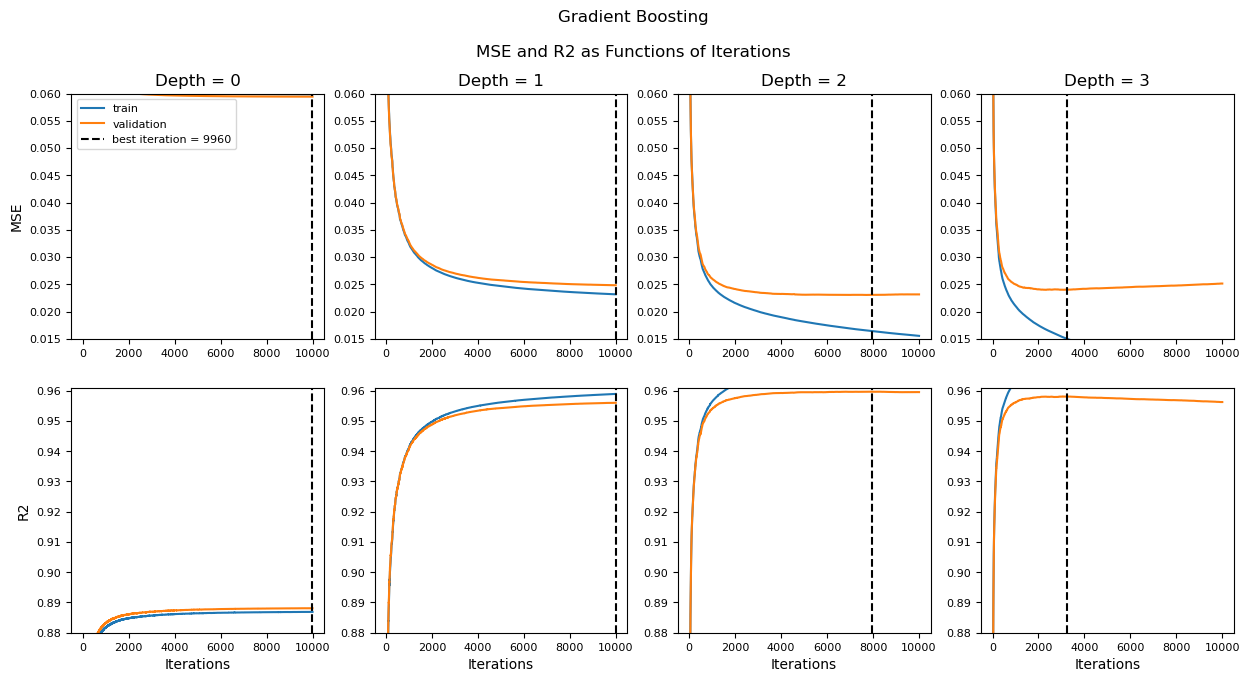

In [17]:
fig, ax = plt.subplots(2, max(depths), figsize=(15,7))
fig.suptitle('Gradient Boosting\n\nMSE and R2 as Functions of Iterations', y=1)

for i in range(max(depths)):
    ax[0,i].plot(iterations, hgb_mses_train[:, i], label='train')
    ax[0,i].plot(iterations, hgb_mses_val[:, i], label='validation')
    ax[1,i].plot(iterations, hgb_r2s_train[:, i], label='train')
    ax[1,i].plot(iterations, hgb_r2s_val[:, i], label='validation')
    ax[0,i].set_title(f'Depth = {i}')
    ax[0,i].set_ylim((0.015, 0.06))
    ax[1,i].set_ylim((0.88, 0.961))
    ax[0,0].set_ylabel('MSE')
    ax[1,0].set_ylabel('R2')
    ax[1,i].set_xlabel('Iterations')
    for j in range(2):
        ax[j,i].axvline(hgb_best_iters[i], c='k', ls='--', label=f'best iteration = {hgb_best_iters[i]}')
        ax[j,i].tick_params(axis='both', which='major', labelsize=8)
ax[0,0].legend(fontsize=8);

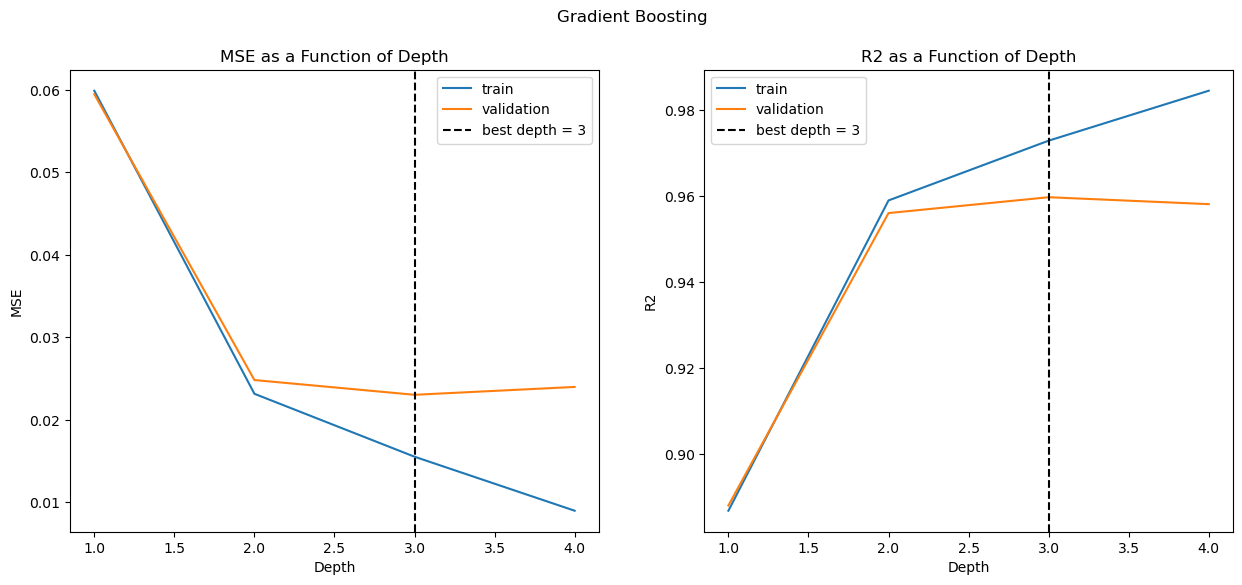

In [18]:
hgb_best_d = depths[np.argmax(np.array(hgb_best_r2s_val))]

fig, ax = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Gradient Boosting')

ax[0].plot(depths, hgb_best_mses_train, label='train')
ax[0].plot(depths, hgb_best_mses_val, label='validation')
ax[1].plot(depths, hgb_best_r2s_train, label='train')
ax[1].plot(depths, hgb_best_r2s_val, label='validation')

ax[0].set_title('MSE as a Function of Depth')
ax[1].set_title('R2 as a Function of Depth')
ax[0].set_ylabel('MSE')
ax[1].set_ylabel('R2')
for i in range(2):
    ax[i].set_xlabel('Depth')
    ax[i].axvline(hgb_best_d, c='k', ls='--', label=f'best depth = {hgb_best_d}')
    ax[i].legend()

In [19]:
# Retrain on the whole train data with the best number of iterations
time0 = time()
model = HistGradientBoostingRegressor(learning_rate=0.5, max_iter=hgb_best_iters[hgb_best_d-1], max_leaf_nodes=None, max_depth=hgb_best_d, min_samples_leaf=1, early_stopping=False)
model.fit(X_train, y_train)
print(f'Time: {round(time()-time0, 1)}s')

Time: 972.2s


In [20]:
print('Train MSE:', mean_squared_error(model.predict(X_train), y_train))
print('Test MSE:', mean_squared_error(model.predict(X_test), y_test))
print('Train R2:', model.score(X_train, y_train))
print('Test R2:', model.score(X_test, y_test))

Train MSE: 0.016719958779210058
Test MSE: 0.022244409973018374
Train R2: 0.9716452850190197
Test R2: 0.9623620476379887


In [21]:
# Save and load
joblib.dump(model, 'results/model.joblib')

In [27]:
model = joblib.load('results/model.joblib')

C:\Users\nazalexx\micromamba\envs\env3106\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator _BinMapper from version 1.3.0 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\nazalexx\micromamba\envs\env3106\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.3.0 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
columns = df.columns.to_list()

In [15]:
binary_parameters = [col for col in columns[1:] if len(col.split(' / '))>1]
choosable_features = list( {col.split(' / ')[0]: 0 for col in binary_parameters}.keys() )
allowed_choices = {cf: sorted([bp.split(' / ')[1] for bp in binary_parameters if cf==bp.split(' / ')[0]]) for cf in choosable_features}

In [16]:
efficient = {}
inefficient = {}
average = {}

for key, values in allowed_choices.items():
    mean_consumptions = {}
    for value in values:
        col = key+' / '+value
        mean_consumptions[value] = df['Total Consumption'][df[col]==1].mean()
    mean_consumptions_values = list(mean_consumptions.values())
    mean_value = np.mean(mean_consumptions_values)
    differences = np.abs(np.array(mean_consumptions_values) - mean_value)
    min_difference_index = np.argmin(differences)
    keys = list(mean_consumptions.keys())
    key_of_closest_element = keys[min_difference_index]
    
    average[key] = key_of_closest_element
    efficient[key] = min(mean_consumptions, key=mean_consumptions.get)
    inefficient[key] = max(mean_consumptions, key=mean_consumptions.get)

In [17]:
nonbinary_parameters = [col for col in columns[1:] if len(col.split(' / '))==1]

def generate_enterable_inputs():
    randomly_chosen_nonbinary = [float(df[col].sample(1).values[0]) for col in nonbinary_parameters]
    enterable_inputs = {key: value for key, value in zip(nonbinary_parameters, randomly_chosen_nonbinary)}
    return enterable_inputs
    
efficient_inputs = {**efficient, **generate_enterable_inputs()}
average_inputs = {**average, **generate_enterable_inputs()}
inefficient_inputs = {**inefficient, **generate_enterable_inputs()}

In [18]:
# Convert user's inputs to model input
def user_inputs_to_model_input(inputs):
    model_input = []
    for col in columns[1:]:
        if len(col.split(' / ')) > 1:
            if col.split(' / ')[1]==inputs[col.split(' / ')[0]]:
                model_input.append(1)
            else:
                model_input.append(0)
        else:
            model_input.append(inputs[col])
    model_input = DataFrame([model_input], columns=columns[1:])
    return model_input

In [29]:
def predict_and_advise(inputs):
    model_inputs_df = user_inputs_to_model_input(inputs)

    ignore_values = ['None', 'Other', 'Other Fuel', 'Uninsulated', 'Finished, Uninsulated', 'Unfinished, Uninsulated']
    for col in changeable_features:
        for value in [value for value in allowed_choices[col] 
                      if value != inputs[col] and value not in ignore_values and 'ninsulated' not in value]:
            new_inputs = inputs.copy()
            new_inputs[col] = value
            new_model_input = user_inputs_to_model_input(new_inputs)
            new_model_input.index = [col + ' / ' + value]
            model_inputs_df = pd.concat([model_inputs_df, new_model_input])
    
    predictions = np.exp(model.predict(model_inputs_df))
    prediction = int(predictions[0])
    reductions = predictions[0] - predictions[1:]
    reductions = {name: int(red) for name, red in zip(list(model_inputs_df.index[1:]), list(reductions))}
    
    reductions = {col: {name.split(' / ')[1]: red for name, red in reductions.items() if col==name.split(' / ')[0]} 
                  for col in changeable_features}
    max_reductions = {key: [max(values, key=values.get), values[max(values, key=values.get)]] for key, values in reductions.items()}

    max_reductions = {k: v for k, v in max_reductions.items() if v[1]>0}
    if len(max_reductions)>0:
        sorted_items = sorted(max_reductions.items(), key = lambda item: item[1][1], reverse=True)
        max_reductions = dict(sorted_items)

    return prediction, max_reductions

In [30]:
t0 = time()
efficient_prediction, efficient_max_reductions = predict_and_advise(efficient_inputs)
time()-t0

1.7009685039520264

In [31]:
t0 = time()
average_prediction, average_max_reductions = predict_and_advise(average_inputs)
time()-t0

1.5560784339904785

In [32]:
t0 = time()
inefficient_prediction, inefficient_max_reductions = predict_and_advise(inefficient_inputs)
time()-t0

1.6764068603515625

In [33]:
efficient_prediction

1408

In [34]:
efficient_max_reductions

{'HVAC Cooling Efficiency': ['Heat Pump', 889],
 'Heating Fuel': ['Electricity', 500],
 'Insulation Foundation Wall': ['Wall R-5, Exterior', 481],
 'HVAC Cooling Partial Space Conditioning': ['<10% Conditioned', 452],
 'Windows': ['Triple, Low-E, Non-metal, Air, L-Gain', 337],
 'Water Heater Efficiency': ['Natural Gas Tankless', 330],
 'Dishwasher': ['290 Rated kWh, 80% Usage', 323],
 'HVAC Heating Efficiency': ['Fuel Furnace, 60% AFUE', 307],
 'Water Heater Fuel': ['Electricity', 277],
 'Insulation Floor': ['Ceiling R-19', 182],
 'Pool Heater': ['Solar', 177],
 'Ducts': ['30% Leakage, R-8', 171],
 'Clothes Dryer': ['Propane, 100% Usage', 162],
 'HVAC Shared Efficiencies': ['Boiler Baseboards Heating Only, Fuel Oil', 161],
 'HVAC Heating Type and Fuel': ['Fuel Oil Fuel Wall/Floor Furnace', 146],
 'Window Areas': ['F6 B6 L6 R6', 142],
 'Clothes Washer': ['Standard, 100% Usage', 139],
 'Insulation Ceiling': ['R-49', 120],
 'Insulation Wall': ['Brick, 12-in, 3-wythe, R-7', 108],
 'Insulat

In [35]:
average_prediction

20469

In [36]:
average_max_reductions

{'Ducts': ['30% Leakage, R-8', 6363],
 'Insulation Roof': ['Finished, R-13', 6254],
 'HVAC Shared Efficiencies': ['Fan Coil Heating and Cooling, Fuel Oil', 5683],
 'HVAC Heating Type and Fuel': ['Fuel Oil Shared Heating', 5239],
 'Clothes Dryer': ['Propane, 80% Usage', 4046],
 'HVAC Cooling Efficiency': ['Heat Pump', 3438],
 'Insulation Ceiling': ['R-49', 2897],
 'Windows': ['Single, Clear, Metal, Exterior Clear Storm', 2125],
 'Water Heater Fuel': ['Electricity', 2096],
 'Hot Tub Spa': ['Electric', 1900],
 'Water Heater Efficiency': ['Fuel Oil Premium', 1816],
 'Insulation Wall': ['CMU, 6-in Hollow, R-15', 1555],
 'Dishwasher': ['318 Rated kWh, 80% Usage', 1456],
 'Cooking Range': ['Propane, 80% Usage', 1437],
 'Lighting': ['100% CFL', 1229],
 'Clothes Washer': ['EnergyStar, 100% Usage', 1030],
 'HVAC Heating Type': ['Non-Ducted Heating', 951],
 'Window Areas': ['F30 B30 L30 R30', 870],
 'Extra Refrigerator': ['EF 15.9', 646],
 'HVAC Cooling Partial Space Conditioning': ['<10% Conditi

In [37]:
inefficient_prediction

88799

In [38]:
inefficient_max_reductions

{'HVAC Shared Efficiencies': ['Boiler Baseboards Heating Only, Fuel Oil',
  22977],
 'Insulation Wall': ['Brick, 12-in, 3-wythe, R-11', 21990],
 'Insulation Foundation Wall': ['Wall R-15, Exterior', 20064],
 'Ducts': ['30% Leakage, R-6', 18575],
 'HVAC Cooling Efficiency': ['Heat Pump', 17370],
 'Insulation Floor': ['Ceiling R-30', 17162],
 'Water Heater Efficiency': ['Propane Standard', 14965],
 'HVAC Heating Efficiency': ['Electric Wall Furnace, 100% AFUE', 14423],
 'HVAC Heating Type and Fuel': ['Fuel Oil Shared Heating', 14344],
 'Insulation Roof': ['Finished, R-19', 13221],
 'Refrigerator': ['EF 6.7, 100% Usage', 11914],
 'Pool Heater': ['Solar', 11892],
 'Windows': ['Single, Clear, Metal, Exterior Clear Storm', 8146],
 'Heating Fuel': ['Electricity', 5606],
 'Clothes Dryer': ['Propane, 100% Usage', 4565],
 'Clothes Washer': ['Standard, 80% Usage', 4472],
 'Hot Tub Spa': ['Gas', 4398],
 'Extra Refrigerator': ['EF 10.2', 4095],
 'HVAC Cooling Type': ['Central AC', 3252],
 'Window A

In [20]:
with open('results/col_descriptions.json', 'w') as f:
    json.dump(col_descriptions['field_description'].to_dict(), f)

In [21]:
with open('results/allowed_choices.json', 'w') as f:
    json.dump(allowed_choices, f)

In [22]:
with open('results/columns.json', 'w') as f:
    json.dump(columns, f)

In [23]:
with open('results/changeable_features.json', 'w') as f:
    json.dump(changeable_features, f)

In [24]:
with open('results/efficient_inputs.json', 'w') as f:
    json.dump(efficient_inputs, f)

In [25]:
with open('results/average_inputs.json', 'w') as f:
    json.dump(average_inputs, f)

In [26]:
with open('results/inefficient_inputs.json', 'w') as f:
    json.dump(inefficient_inputs, f)

In [44]:
with open('results/col_descriptions.json', 'r') as f:
    col_descriptions = json.load(f)

In [45]:
with open('results/allowed_choices.json', 'r') as f:
    allowed_choices = json.load(f)

In [46]:
with open('results/columns.json', 'r') as f:
    columns = json.load(f)

In [47]:
with open('results/changeable_features.json', 'r') as f:
    changeable_features = json.load(f)

In [48]:
with open('results/efficient_inputs.json', 'r') as f:
    efficient_inputs = json.load(f)

In [49]:
with open('results/average_inputs.json', 'r') as f:
    average_inputs = json.load(f)

In [50]:
with open('results/inefficient_inputs.json', 'r') as f:
    inefficient_inputs = json.load(f)